Copyright Preferred Computational Chemistry, Inc. and Preferred Networks, Inc. as contributors to Matlantis contrib project

This notebook was machine translated from Japanese to English.

# A Comprehensive Guide to NPT Molecular Dynamics Simulations

## Setting the Stage

The crystallographic information file (CIF) for SiO2 was sourced from the esteemed Materials Project database.<br/>
For detailed instructions, kindly refer to the "Import material from Material Project" option in the Launcher menu.
 - https://materialsproject.org/materials/mp-6945/
 - https://materialsproject.org/materials/mp-546794/

The input CIF files were obtained from the following seminal work:\
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)\
The Materials Project: A materials genome approach to accelerating materials innovation\
APL Materials, 2013, 1(1), 011002.\
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)\
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)\
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [ ]:
!pip install pfp_api_client
!pip install matplotlib ase

# Please install the libraries only for the first use.

In [1]:
import ase
from ase.build import molecule
from ase.visualize import view

ase.__version__

'3.22.0'

In [2]:
from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator

estimator = Estimator()
calculator = ASECalculator(estimator)

In [3]:
import os

os.makedirs("output", exist_ok=True)

The SiO2 structure under investigation in this study

In [4]:
import ase.io
from ase.visualize import view

atoms = ase.io.read("input/SiO2_mp-6945_computed.cif")
atoms *= (4, 3, 3)

v = view(atoms, viewer='ngl')
v.view.add_ball_and_stick()
display(v)

## Isotropic Control in NPT Ensemble
### Approach 1: Mask Specification (Fixed Cell Angles)

By specifying (3, 3) in the mask parameter of the NPT class, one can dictate the direction of change for the Cell.<br/>
Specifying `np.eye(3)` enables molecular dynamics simulations with fixed angles.
 - https://wiki.fysik.dtu.dk/ase/ase/md.html#module-ase.md.npt

In [5]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.npt import NPT
from ase.md.nptberendsen import NPTBerendsen
from ase.io import Trajectory
from ase import units

from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator

from time import perf_counter
import numpy as np

atoms = ase.io.read("input/SiO2_mp-6945_computed.cif")
atoms *= (4, 3, 3)
atoms.calc = calculator


# In ase version>=3.21.0, specifying temperature_K is recommended.
MaxwellBoltzmannDistribution(
    atoms,
    temperature_K=300.0
)
Stationary(atoms)
dyn = NPT(atoms,
          1.0 * units.fs,
          temperature_K=300,
          externalstress=101325 * units.Pascal,
          mask=np.eye(3),  # Specify np.eye(3) here
          ttime=10 * units.fs,
          pfactor=100 * units.fs,
          logfile="output/sio2.log",
          trajectory="output/sio2.traj")


start_time = perf_counter()

def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, energy: {atoms.get_total_energy():.3f}, elapsed_time: {perf_counter() - start_time:.2f} sec")

dyn.attach(print_dyn, interval=10)
dyn.run(100)

Dyn  step:  10, energy: -2720.284, elapsed_time: 3.49 sec
Dyn  step:  20, energy: -2710.637, elapsed_time: 6.69 sec
Dyn  step:  30, energy: -2694.522, elapsed_time: 9.88 sec
Dyn  step:  40, energy: -2691.940, elapsed_time: 13.04 sec
Dyn  step:  50, energy: -2703.926, elapsed_time: 16.20 sec
Dyn  step:  60, energy: -2708.250, elapsed_time: 19.36 sec
Dyn  step:  70, energy: -2707.254, elapsed_time: 22.53 sec
Dyn  step:  80, energy: -2704.370, elapsed_time: 25.72 sec
Dyn  step:  90, energy: -2703.853, elapsed_time: 28.93 sec
Dyn  step: 100, energy: -2705.025, elapsed_time: 32.13 sec


**Examining Cell Size**

While the lengths of the a, b, and c axes undergo changes, the angles remain unaltered.

In [6]:
traj = Trajectory("output/sio2.traj")
cell_size_history = [atoms.cell.cellpar() for atoms in traj]

# To reduce the amount of print output, check every 10 steps
cell_size_history[::10]

[array([20.338804, 15.254103, 21.295737, 90.      , 90.      , 90.      ]),
 array([20.34709056, 15.25997189, 21.30078079, 90.        , 90.        ,
        90.        ]),
 array([20.36662827, 15.27483021, 21.31356124, 90.        , 90.        ,
        90.        ]),
 array([20.38826633, 15.29445575, 21.33151445, 90.        , 90.        ,
        90.        ]),
 array([20.4053848 , 15.31091376, 21.34388992, 90.        , 90.        ,
        90.        ]),
 array([20.40853203, 15.31629593, 21.33536484, 90.        , 90.        ,
        90.        ]),
 array([20.38617267, 15.30688091, 21.3034135 , 90.        , 90.        ,
        90.        ]),
 array([20.34711366, 15.28739519, 21.25958074, 90.        , 90.        ,
        90.        ]),
 array([20.31370621, 15.27012572, 21.22078718, 90.        , 90.        ,
        90.        ]),
 array([20.29884377, 15.26646011, 21.20456456, 90.        , 90.        ,
        90.        ])]

In [7]:
v = view(traj, viewer='ngl')
v.view.add_ball_and_stick()
display(v)

### Approach 2: Leveraging Filters (Preserving Cell Length Ratios)

By post-processing the Stress tensor to maintain uniform magnitudes, the ratios of the cell lengths can be preserved. The methodology is outlined below.

In [8]:
import numpy as np
from ase.constraints import Filter



class IsotropicFilter(Filter):
    def __init__(self, atoms, indices=None, mask=None):
        if indices is None and mask is None:
            # Apply filter for all atoms
            indices = np.arange(atoms.get_global_number_of_atoms())
        super(IsotropicFilter, self).__init__(atoms, indices, mask)

    def get_stress(self, **kwargs):
        cell = self.atoms.get_cell()
        stresses = self.atoms.get_stress(**kwargs)
        if stresses.shape != (6,):
            raise ValueError(f"Error: stresses.shape {stresses.shape}")
        stresses[3:] = 0.0
        pressure = np.mean(stresses[:3])
        stresses[:3] = pressure
        return stresses

    def get_temperature(self):
        return self.atoms.get_temperature()

    def get_total_energy(self):
        return self.atoms.get_total_energy()

    def get_kinetic_energy(self):
        return self.atoms.get_kinetic_energy()

    def get_global_number_of_atoms(self):
        return self.atoms.get_global_number_of_atoms()

    def set_cell(self, cell, scale_atoms=False, apply_constraint=True):
        return self.atoms.set_cell(
            cell, scale_atoms=scale_atoms, apply_constraint=apply_constraint
        )

In [9]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.npt import NPT
from ase.md.nptberendsen import NPTBerendsen
from ase.io import Trajectory
from ase.build import bulk
from ase import units

from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator

from time import perf_counter
import numpy as np

atoms = bulk("Si", cubic = True)
atoms *= (4, 3, 3)
atoms.calc = calculator

# Apply the Filter to atoms
iso_atoms = IsotropicFilter(atoms)
MaxwellBoltzmannDistribution(iso_atoms, temperature_K=300.0)
Stationary(iso_atoms)
dyn = NPT(iso_atoms,
          1.0 * units.fs,
          temperature_K=300,
          externalstress=101325 * units.Pascal,
          mask=np.eye(3),
          ttime=10 * units.fs,
          pfactor=100 * units.fs,
          logfile="output/si_iso.log",
          trajectory="output/si_iso.traj")


start_time = perf_counter()
def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, energy: {atoms.get_total_energy():.3f}, elapsed_time: {perf_counter() - start_time:.2f} sec")
dyn.attach(print_dyn, interval=10)
dyn.run(100)

Dyn  step:  10, energy: -1298.112, elapsed_time: 2.18 sec
Dyn  step:  20, energy: -1294.476, elapsed_time: 4.16 sec
Dyn  step:  30, energy: -1279.642, elapsed_time: 6.09 sec
Dyn  step:  40, energy: -1281.333, elapsed_time: 7.98 sec
Dyn  step:  50, energy: -1286.203, elapsed_time: 9.81 sec
Dyn  step:  60, energy: -1282.718, elapsed_time: 11.63 sec
Dyn  step:  70, energy: -1273.227, elapsed_time: 13.45 sec
Dyn  step:  80, energy: -1280.578, elapsed_time: 15.30 sec
Dyn  step:  90, energy: -1282.381, elapsed_time: 17.12 sec
Dyn  step: 100, energy: -1284.916, elapsed_time: 18.98 sec


Verify the ratio of Cell lengths `a:b:c`. It becomes evident that the ratio remains constant throughout the simulation.

In [10]:
traj = Trajectory("output/si_iso.traj")
cell_size_history = [atoms.cell.cellpar() for atoms in traj]

cell_length_history = np.array([atoms.get_cell_lengths_and_angles()[:3] for atoms in traj])

# To reduce the amount of print output, check every 10 steps
cell_length_ratio_history = cell_length_history / cell_length_history[:, 0:1]
print("a:b:c = \n", cell_length_ratio_history[::10])

a:b:c = 
 [[1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]
 [1.   0.75 0.75]]


/home/jovyan/.local/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


However, the actual Cell lengths exhibit variations.

In [11]:
print("a,b,c = \n", cell_length_history[::10])

a,b,c = 
 [[21.72       16.29       16.29      ]
 [21.7356418  16.30173135 16.30173135]
 [21.77517368 16.33138026 16.33138026]
 [21.83240146 16.37430109 16.37430109]
 [21.89665807 16.42249356 16.42249356]
 [21.95295893 16.4647192  16.4647192 ]
 [21.98924709 16.49193532 16.49193532]
 [21.99966685 16.49975014 16.49975014]
 [21.98592141 16.48944105 16.48944105]
 [21.95324602 16.46493451 16.46493451]]


## Extracting Density and Volume through Post-processing

The Trajectory instance provides access to the Atoms information at each Frame.<br/>
Ase atoms offers the `get_volume` and `get_global_number_of_atoms` functions, which can be readily utilized.

In [12]:
# cell_list = [atoms.cell for atoms in traj]

volume_list = [atoms.get_volume() for atoms in traj]
density_list = [atoms.get_global_number_of_atoms() / atoms.get_volume() for atoms in traj]

In [13]:
print(volume_list)
print(density_list)

[5763.708251999998, 5764.131707178368, 5764.553834457096, 5765.395785246378, 5766.235719316216, 5767.48975024803, 5768.742057145161, 5770.400739141297, 5772.058871091771, 5774.113555362282, 5776.169542055843, 5778.609989119666, 5781.053978471361, 5783.867838795086, 5786.687509375583, 5789.859725415075, 5793.039666921781, 5796.551906389886, 5800.0731450987, 5803.903457723219, 5807.743265920976, 5811.866075304465, 5815.998187935012, 5820.384763044434, 5824.780054012687, 5829.399356050736, 5834.026786906732, 5838.846429752368, 5843.673863376523, 5848.660450369243, 5853.654057532671, 5858.771470356455, 5863.893017166693, 5869.099187710506, 5874.30307612228, 5879.548151579635, 5884.781362135775, 5890.009561282161, 5895.215120088264, 5900.369365913755, 5905.49133912333, 5910.517666844609, 5915.504455254107, 5920.354094271415, 5925.159373090376, 5929.788761936238, 5934.370890390756, 5938.740762714563, 5943.061813055538, 5947.136302720512, 5951.161299392146, 5954.907390782732, 5958.60401212543

Visualize and scrutinize the evolution of the system

In [14]:
energy_list = [atoms.get_potential_energy() for atoms in traj]
temperature_list = [atoms.get_temperature() for atoms in traj]

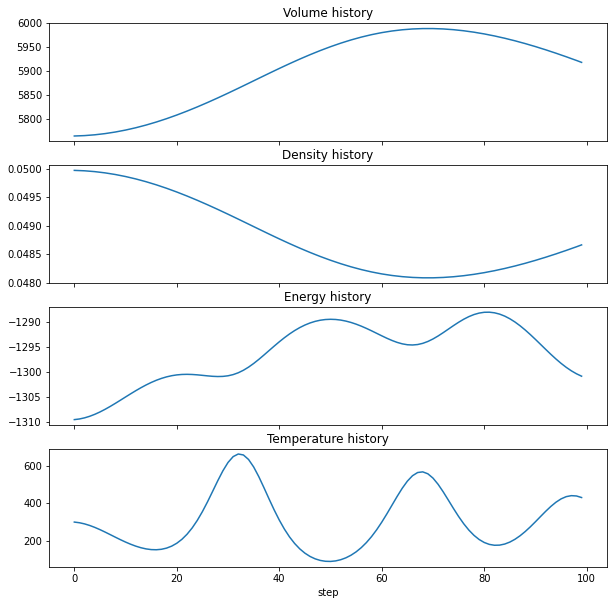

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

axes[0].plot(volume_list)
axes[0].set_title("Volume history")

axes[1].plot(density_list)
axes[1].set_title("Density history")

axes[2].plot(energy_list)
axes[2].set_title("Energy history")

axes[3].plot(temperature_list)
axes[3].set_title("Temperature history")
axes[3].set_xlabel("step")

fig.savefig("output/md_stats_history.png")

* With approximately 100 steps, the temperature may not stabilize.

## NPT Molecular Dynamics in Triclinic Systems

The NPT module in ase necessitates that the cell of `atoms` is represented as an upper triangular matrix, akin to the following:

```
[[X X X]
 [0 X X]
 [0 0 X]]
```

The `convert_atoms_to_upper` function rotates the `atoms` to transform the Cell into an upper triangular matrix.


In [16]:
from ase import Atoms
import numpy as np


def convert_atoms_to_upper(atoms: Atoms) -> Atoms:
    atoms2 = atoms.copy()
    
    # cell "c" -> z-axis
    atoms2.rotate(atoms2.cell[2], (0, 0, 1), rotate_cell=True)

    # cell "b" -> yz-plane
    bx, by, bz = atoms2.cell[1, :]
    angle = 90.0 - np.rad2deg(np.arctan2(by, bx))
    atoms2.rotate(angle, 'z', rotate_cell=True)
    # [Note] cell "a" can be arbitrary.

    # supress numerical precision, lower triangular values must be 0.0.
    atoms2.cell = np.where(np.abs(atoms2.cell) < 1e-10, 0.0, atoms2.cell)

    # Check that cell is uppper triangular form.
    m = atoms2.cell
    assert m[1, 0] == m[2, 0] == m[2, 1] == 0.0, f"cell {m} is not upper triangular!"
    return atoms2

In [17]:
atoms = ase.io.read("input/SiO2_mp-546794_computed.cif")
atoms.cell  # NOT upper tiangular

Cell([[5.13584237, 0.0, 0.0], [0.15785281555277758, 5.133415952181283, 0.0], [-2.646847592991795, -2.566707976299526, 3.575344016085885]])

In [18]:
atoms = convert_atoms_to_upper(atoms)
atoms.cell  # This is upper tiangular

Cell([[4.170109258320234, -1.407573601142272, -2.646847592991795], [0.0, 4.401258305185092, -2.646847592991795], [0.0, 0.0, 5.135842369999999]])

In [19]:
atoms = ase.io.read("input/SiO2_mp-546794_computed.cif") * (2, 2, 3)
# If you comment out the line below, the NPT Module will generate an error.
# NotImplementedError: Can (so far) only operate on lists of atoms where the computational box is an upper triangular matrix.
atoms = convert_atoms_to_upper(atoms)
atoms.calc = calculator
MaxwellBoltzmannDistribution(atoms, temperature_K=300.0)
Stationary(atoms)
dyn = NPT(atoms,
          1.0 * units.fs,
          temperature_K=300,
          externalstress=101325 * units.Pascal,
          mask=np.eye(3),
          ttime=10 * units.fs,
          pfactor=100 * units.fs,
          logfile="output/si_tri.log",
          trajectory="output/si_tri.traj")


start_time = perf_counter()
def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, energy: {atoms.get_total_energy():.3f}, elapsed_time: {perf_counter() - start_time:.2f} sec")
dyn.attach(print_dyn, interval=10)
dyn.run(100)

Dyn  step:  10, energy: -453.486, elapsed_time: 1.29 sec
Dyn  step:  20, energy: -451.625, elapsed_time: 2.46 sec
Dyn  step:  30, energy: -448.398, elapsed_time: 3.67 sec
Dyn  step:  40, energy: -448.321, elapsed_time: 4.85 sec
Dyn  step:  50, energy: -451.135, elapsed_time: 6.00 sec
Dyn  step:  60, energy: -452.141, elapsed_time: 7.19 sec
Dyn  step:  70, energy: -451.945, elapsed_time: 8.34 sec
Dyn  step:  80, energy: -450.731, elapsed_time: 9.50 sec
Dyn  step:  90, energy: -450.171, elapsed_time: 10.66 sec
Dyn  step: 100, energy: -450.561, elapsed_time: 11.84 sec


Remarkably, molecular dynamics simulations can be successfully executed even in triclinic systems.

## Visualization Techniques

### nglview

Employing nglviewer enables the interactive visualization of Trajectories.\
*: It is worth noting that nglviewer preserves the bond and Cell state of the initial frame and does not render the addition or deletion of atoms.

In [20]:
traj = Trajectory("output/si_iso.traj")
v = view(traj[::10], viewer='ngl')
v.view.add_ball_and_stick()
display(v)

### Exporting as a GIF File

Apart from nglview, it is also feasible to generate a GIF using the default functionality provided by ase.<br/>
To mitigate the computational burden of visualization, rendering is performed every 10 steps.

MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: user 7.77 s, sys: 276 ms, total: 8.05 s
Wall time: 8.03 s


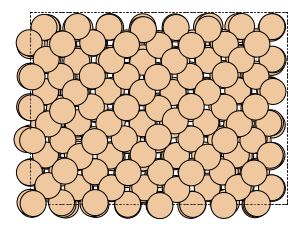

In [21]:
%%time
traj = Trajectory("output/si_iso.traj")
traj_small = [atoms for atoms in traj[::10]]
ase.io.write("output/si_iso.gif", traj_small, rotation="-90x,0y,0z")

In [22]:
from IPython.display import Image
Image(url='output/si_iso.gif')  

### Harnessing Alternative Visualization Tools

Save the traj file in a different format.<br/>
In this instance, conversion to xyz and pdb files is carried out. By downloading the saved files, they can be visualized using separate software packages such as [VMD](https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD) and [OVITO](https://www.ovito.org/).

In [23]:
from ase.io import write

traj = Trajectory("output/sio2.traj")
write("output/sio2.xyz", traj)
write("output/sio2.pdb", traj)